<a href="https://colab.research.google.com/github/funabashi800/bandGapEstimation/blob/master/InSb_BandGap_Estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# filter warnings messages from the notebook
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Set pandas view options
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
from matminer.data_retrieval.retrieve_MP import MPDataRetrieval

api_key = "My API Key"  # Set your MP API key here. If set as an environment variable 'MAPI_KEY', set it to 'None'
mpr = MPDataRetrieval(api_key)     # Create an adapter to the MP Database.

# criteria is to get all binary compounds
criteria = {'nelements': 2}

# properties are the materials attributes we want
# See https://github.com/materialsproject/mapidoc for available properties you can specify
properties = ['pretty_formula', 'spacegroup.symbol', 'formation_energy_per_atom', 'band_gap', 'e_above_hull', 
              'density', 'volume', 'nsites']

# get the data!
df_mp = mpr.get_dataframe(criteria=criteria, properties=properties)
print('Number of binary compounds extracted = {}'.format(len(df_mp)))

Number of binary compounds extracted = 13860


In [38]:
insb = mpr.get_dataframe(criteria={'pretty_formula': 'InSb'}, properties=properties)
print('Number of binary compounds extracted = {}'.format(len(insb)))

Number of binary compounds extracted = 9


In [6]:
df_mp.head()

,pretty_formula,spacegroup.symbol,formation_energy_per_atom,band_gap,e_above_hull,density,volume,nsites
material_id,,,,,,,,
mp-865950,AcAg3,P6_3/mmc,-0.206854,0.0000,0.0,8.930827,204.751583,8
mp-866199,AcAg,Pm-3m,-0.268366,0.0000,0.0,8.859009,62.767941,2
mp-862617,AcAl3,P6_3/mmc,-0.368426,0.0000,0.0,5.243536,195.041675,8
mp-867838,AcAu3,P6_3/mmc,-0.693050,0.0000,0.0,13.755798,197.466462,8
mp-27972,AcBr3,P6_3/m,-2.103586,4.1045,0.0,5.570195,278.264428,8


In [39]:
# Originaly all of the data of band gap in the database is zero!
insb

,pretty_formula,spacegroup.symbol,formation_energy_per_atom,band_gap,e_above_hull,density,volume,nsites
material_id,,,,,,,,
mp-684597,InSb,Imm2,0.007750,0.0,0.134845,6.896150,56.966136,2
mp-569020,InSb,Pmmn,0.009746,0.0,0.136842,6.935338,113.288489,4
mp-20012,InSb,F-43m,-0.127096,0.0,0.000000,5.384060,72.964821,2
mp-1007661,InSb,P6_3mc,-0.115320,0.0,0.011776,5.369502,146.325303,4
mp-10148,InSb,Pm-3m,0.110811,0.0,0.237906,7.116261,55.204131,2
mp-10149,InSb,Fm-3m,0.020779,0.0,0.147875,6.765321,58.067758,2
mp-19744,InSb,Pmm2,0.065197,0.0,0.192293,6.693283,58.692722,2
mp-21210,InSb,Cmcm,0.022714,0.0,0.149810,6.792776,115.666110,4
mp-20253,InSb,Cmcm,-0.006128,0.0,0.120968,6.771521,348.087529,12


In [0]:
df_mp = df_mp[df_mp['e_above_hull'] < 0.1]
insb = insb[insb['e_above_hull'] < 0.1 ]

In [10]:
df_mp.describe()

,formation_energy_per_atom,band_gap,e_above_hull,density,volume,nsites
count,9466.000000,9466.000000,9466.000000,9466.000000,9466.000000,9466.000000
mean,-0.789770,0.656388,0.016517,6.735374,353.815080,16.202197
std,0.924913,1.393007,0.026054,3.544205,529.972765,22.339041
min,-4.522664,0.000000,0.000000,0.222775,11.917209,2.000000
25%,-1.020084,0.000000,0.000000,4.066123,92.376327,4.000000
50%,-0.448040,0.000000,0.000469,6.309683,175.963398,8.000000
75%,-0.169640,0.515575,0.023895,8.631621,373.343771,17.000000
max,0.099969,9.061200,0.099988,21.676369,6897.599713,196.000000


In [11]:
insb.describe()

,formation_energy_per_atom,band_gap,e_above_hull,density,volume,nsites
count,2.000000,2.0,2.000000,2.000000,2.000000,2.000000
mean,-0.121208,0.0,0.005888,5.376781,109.645062,3.000000
std,0.008327,0.0,0.008327,0.010294,51.873694,1.414214
min,-0.127096,0.0,0.000000,5.369502,72.964821,2.000000
25%,-0.124152,0.0,0.002944,5.373142,91.304942,2.500000
50%,-0.121208,0.0,0.005888,5.376781,109.645062,3.000000
75%,-0.118264,0.0,0.008832,5.380421,127.985183,3.500000
max,-0.115320,0.0,0.011776,5.384060,146.325303,4.000000


In [0]:
# add volume per atom descriptor
df_mp['vpa'] = df_mp['volume']/df_mp['nsites']
insb['vpa'] = insb['volume']/insb['nsites']

In [13]:
# target output column
y = df_mp['band_gap'].values

# possible descriptor columns
X_cols = [c for c in df_mp.columns 
          if c not in ['band_gap', 'pretty_formula', 
                       'volume', 'nsites', 'spacegroup.symbol', 'e_above_hull']]
X = df_mp.as_matrix(X_cols)

print("Possible descriptors are: {}".format(X_cols))

Possible descriptors are: ['formation_energy_per_atom', 'density', 'vpa']


In [14]:
# possible descriptor columns in InSb
X_cols_insb = [c for c in df_mp.columns 
          if c not in ['band_gap', 'pretty_formula', 
                       'volume', 'nsites', 'spacegroup.symbol', 'e_above_hull']]
X_insb = insb.as_matrix(X_cols_insb)

print("Possible descriptors are: {}".format(X_cols_insb))

Possible descriptors are: ['formation_energy_per_atom', 'density', 'vpa']


In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

linear_regression = LinearRegression()

linear_regression.fit(X, y)

# get fit statistics
print ('R2 = ' + str(round(linear_regression.score(X, y), 3)))
print ('RMSE = %.3f' % np.sqrt(mean_squared_error(y_true=y, y_pred=linear_regression.predict(X))))

R2 = 0.463
RMSE = 1.020


Text(0.5,1,'Random forest regression')

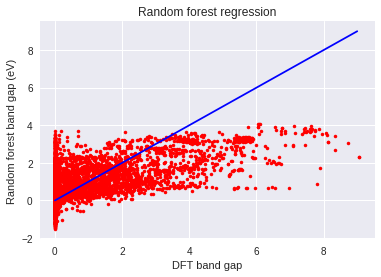

In [25]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
line1 = ax.plot(y,linear_regression.predict(X), "r.")
line2 = ax.plot([0,1,2,3,4,5,6,7,8,9], "b")
ax.set_xlabel('DFT band gap')
ax.set_ylabel('Random forest band gap (eV)')
ax.set_title('Random forest regression')

In [35]:
from sklearn.ensemble import RandomForestRegressor

RF_rg = RandomForestRegressor(n_estimators=50, random_state=1)

RF_rg.fit(X, y)
print ('R2 = ' + str(round(RF_rg.score(X, y), 3)))
print ('RMSE = %.3f' % np.sqrt(mean_squared_error(y_true=y, y_pred=RF_rg.predict(X))))

R2 = 0.975
RMSE = 0.221


Text(0.5,1,'Random forest regression')

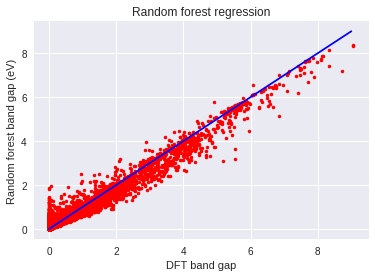

In [19]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
line1 = ax.plot(y, RF_rg.predict(X), "r.")
line2 = ax.plot([0,1,2,3,4,5,6,7,8,9], "b")
ax.set_xlabel('DFT band gap')
ax.set_ylabel('Random forest band gap (eV)')
ax.set_title('Random forest regression')


In [20]:
from sklearn.cross_validation import KFold, cross_val_score

# Use 10-fold cross validation (90% training, 10% test)
crossvalidation = KFold(n=X.shape[0], n_folds=10, shuffle=True, random_state=1)

# compute cross validation scores for random forest model
scores = cross_val_score(linear_regression, X, y, scoring='neg_mean_squared_error', 
                         cv=crossvalidation, n_jobs=1)
rmse_scores = [np.sqrt(abs(s)) for s in scores]

print ('Cross-validation results:')
print ('Folds: %i, mean RMSE: %.3f' % (len(scores), np.mean(np.abs(rmse_scores))))

Cross-validation results:
Folds: 10, mean RMSE: 1.020


In [24]:
# Prediction Result of Band Gap in InSb
print("Expected Band Gap of InSb is : {} eV".format(RF_rg.predict(X_insb)[1]))

Expected Band Gap of InSb is : 0.169242 eV
